## Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import os

## Read dataset

In [2]:
train = pd.read_csv('./dataset/train.csv')
train.head()

content         label
0  1,5 tỷ đồng đầu tư được bất động sản gì? \nTP ...  bat-dong-san
1  1,5 tỷ đồng mua được căn hộ nào ở TP HCM? \nTP...  bat-dong-san
2  10 kinh nghiệm làm nhà cuối năm \nCuối năm, cá...  bat-dong-san
3  10 lỗi thường gặp khi bố trí đèn nhà ở \nCác l...  bat-dong-san
4  10 sai lầm decor khiến nhà kém sang \nLựa chọn...  bat-dong-san

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32245 entries, 0 to 32244
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  32245 non-null  object
 1   label    32245 non-null  object
dtypes: object(2)
memory usage: 504.0+ KB


## Data Cleaning

In [4]:
train.isnull().sum()

content    0
label      0
dtype: int64

In [5]:
train.duplicated().sum()

1

In [6]:
train.drop_duplicates(inplace=True)

In [7]:
from underthesea import text_normalize
from underthesea import word_tokenize

### Normalize data and word tokenize

In [8]:
def text_preprocess(text):
    text = text_normalize(text)
    text = word_tokenize(text, format="text")
    text = text.lower()
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
train["cleaned_content"] = train["content"].apply(lambda x: text_preprocess(x))

### Remove stopwords

In [9]:
with open('./stopwords/vietnamese_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = set(f.read().splitlines())
def remove_stopwords(text, stopwords):
    words = text.split()  
    cleaned_words = [word for word in words if word.lower() not in stopwords]
    cleaned_text = " ".join(cleaned_words) 
    return cleaned_text

train["cleaned_content"] = train["cleaned_content"].apply(lambda x: remove_stopwords(x, stopwords))

## Data Visualization

In [10]:
content_data = train['cleaned_content']

### Histogram length of articles

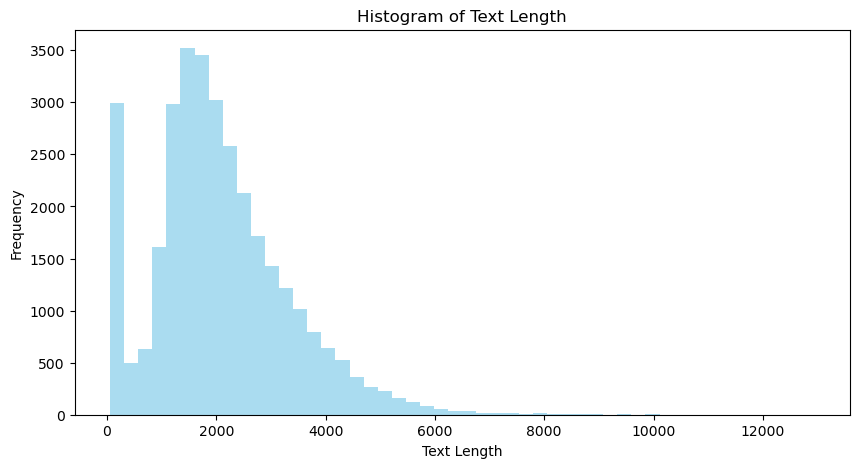

In [11]:
# Tạo histogram của độ dài các đoạn văn bản
text_lengths = content_data.apply(len)
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=50, color='skyblue', alpha=0.7)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Length')
plt.show()

###  Check numbers of labels, check balance of labels

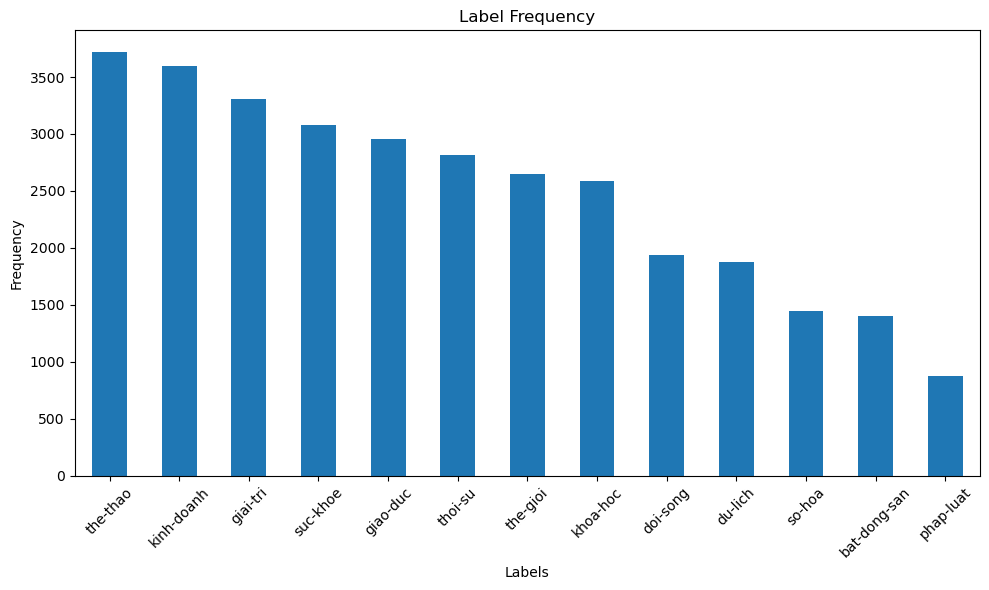

In [12]:
labels = train['label']  
label_counts = labels.value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Top 20 most frequent word for each labels

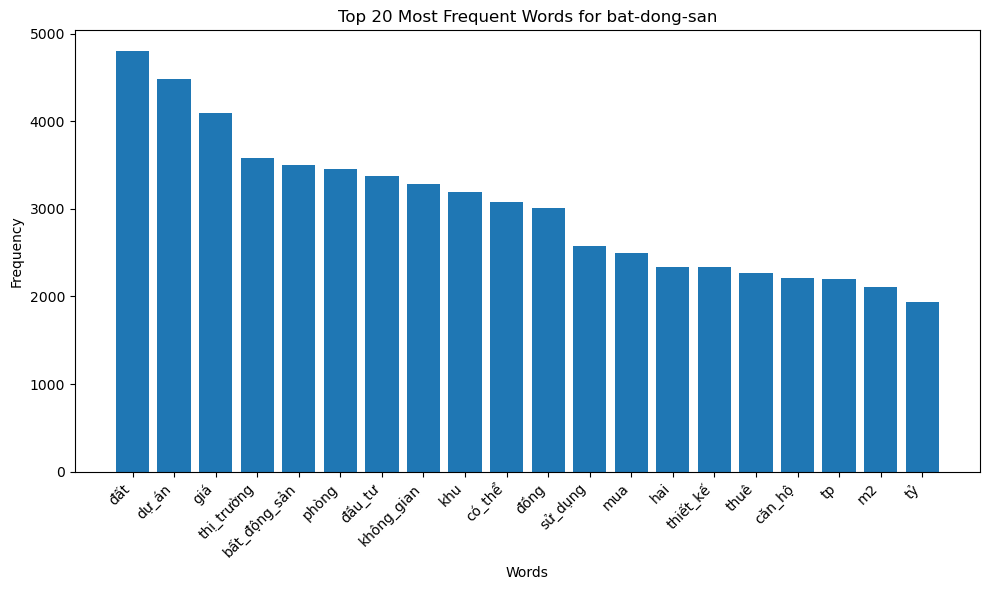

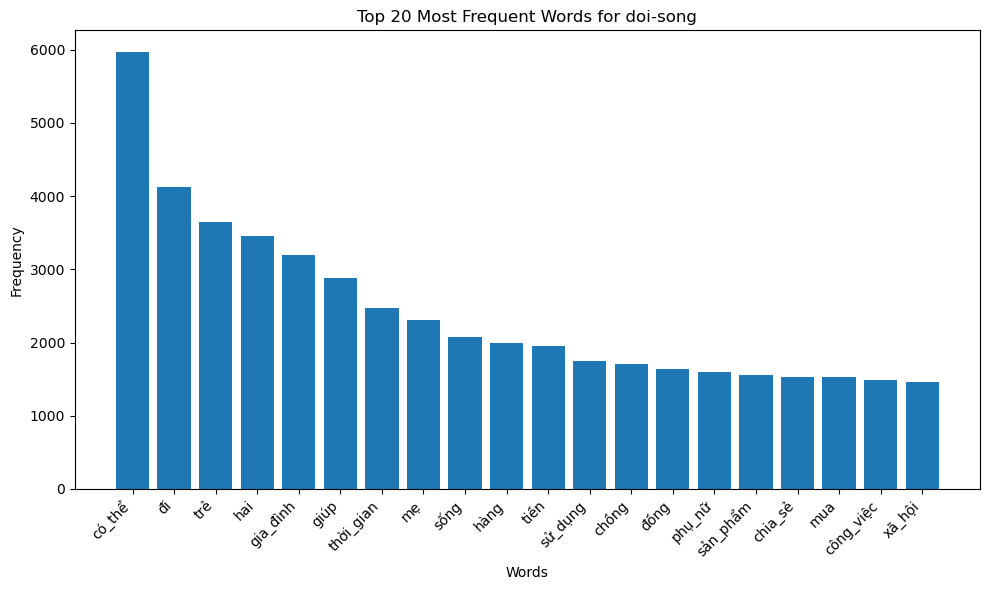

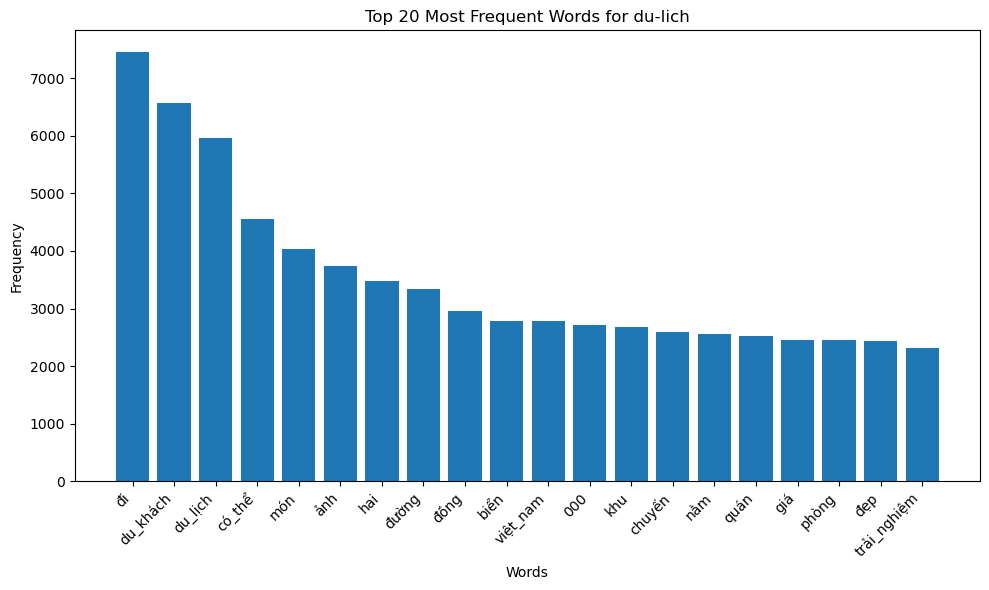

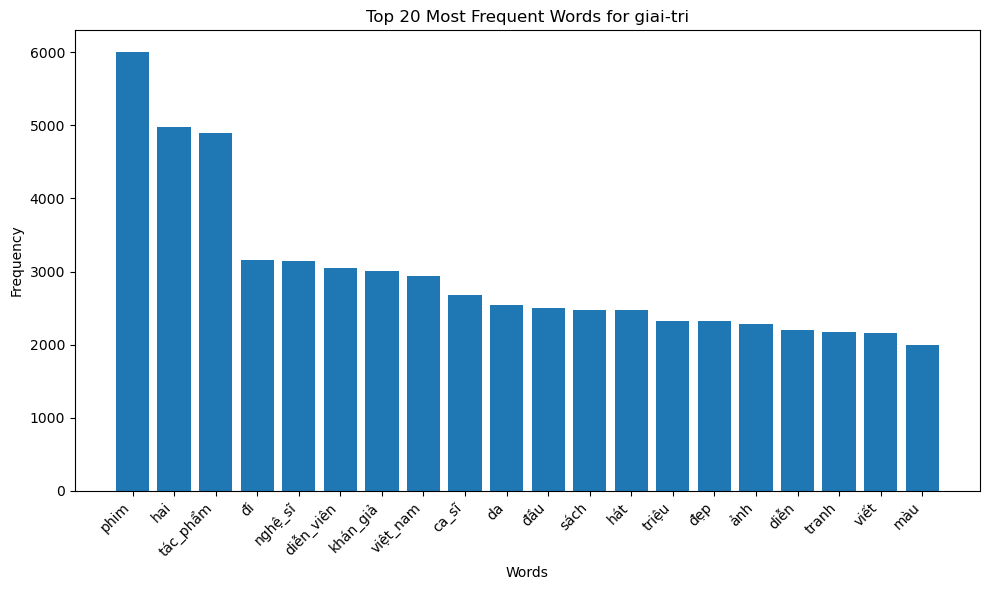

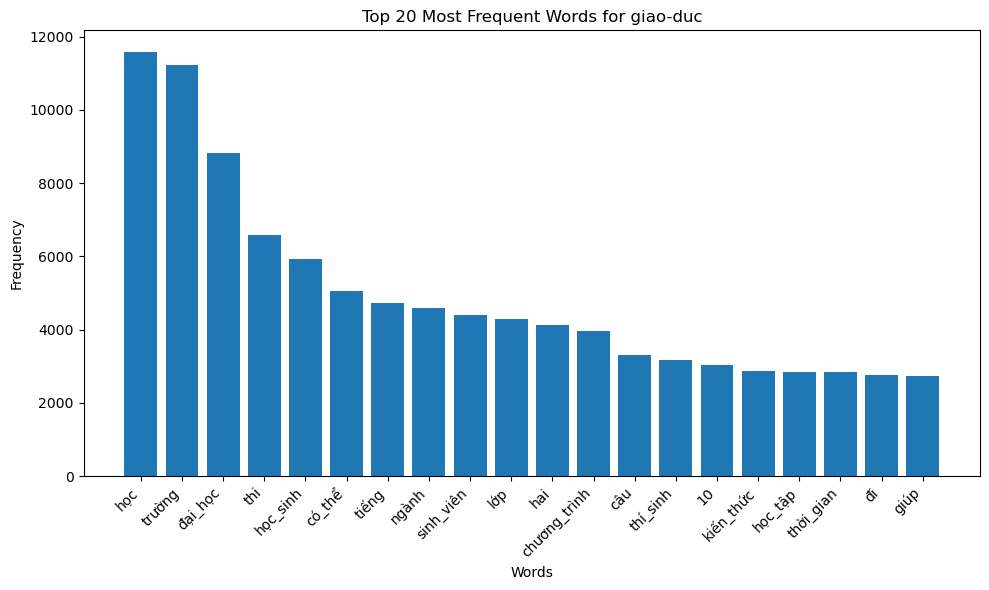

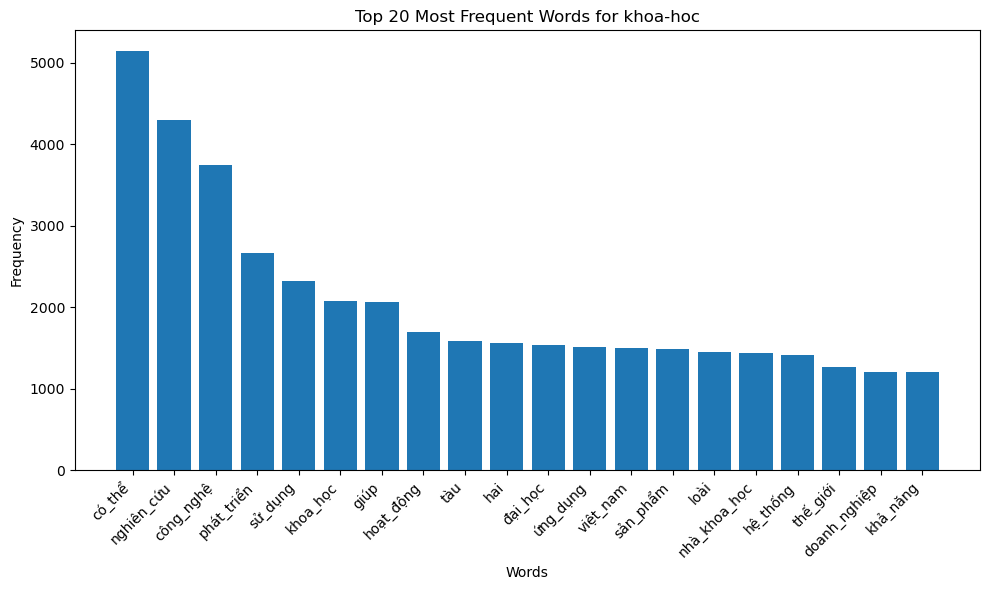

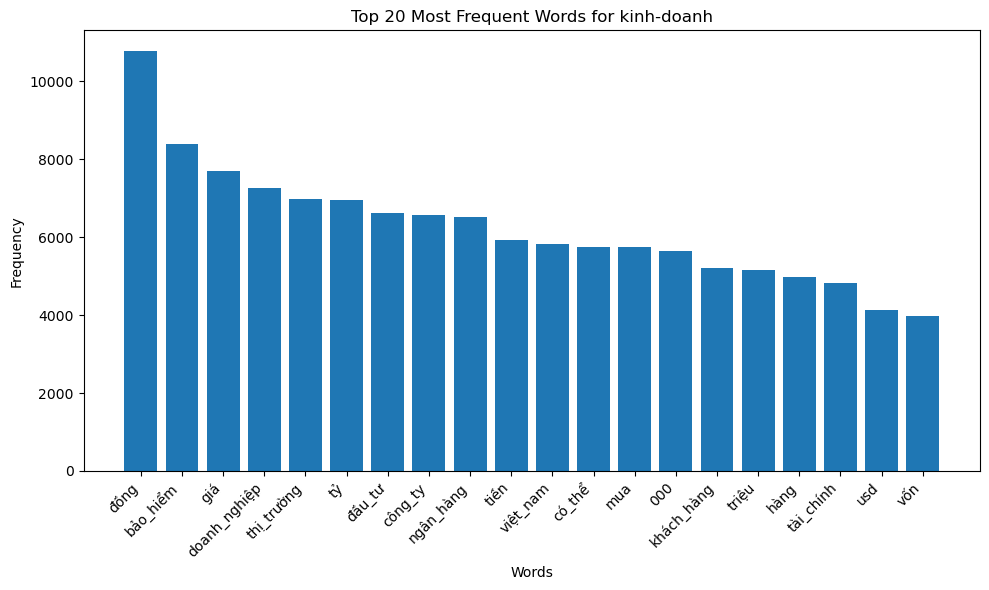

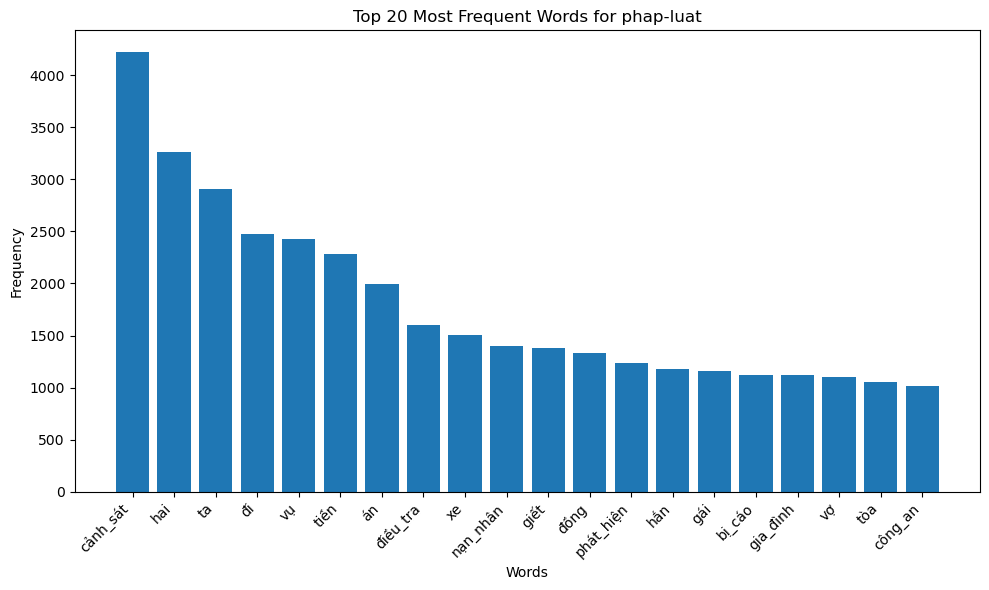

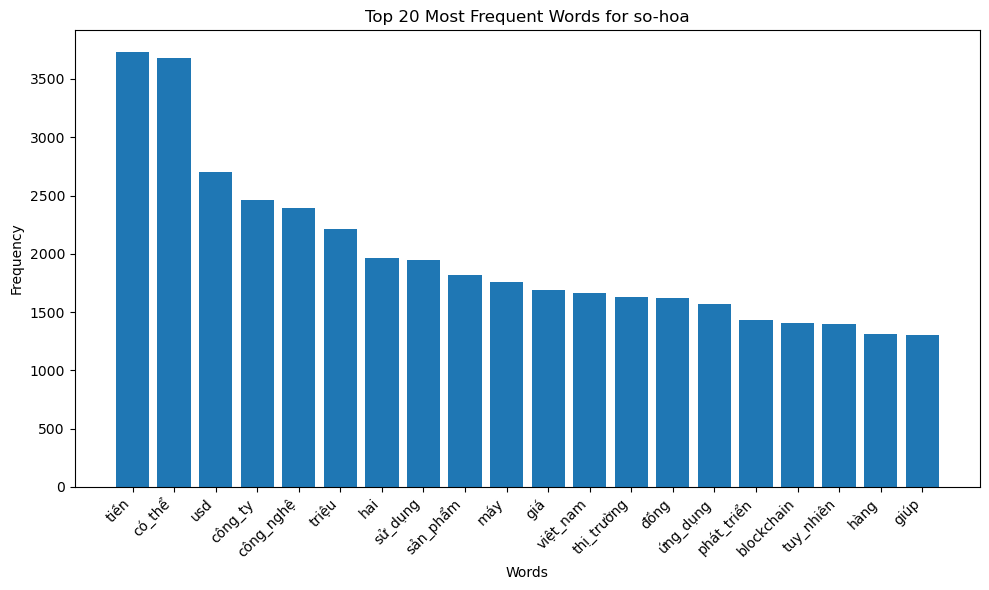

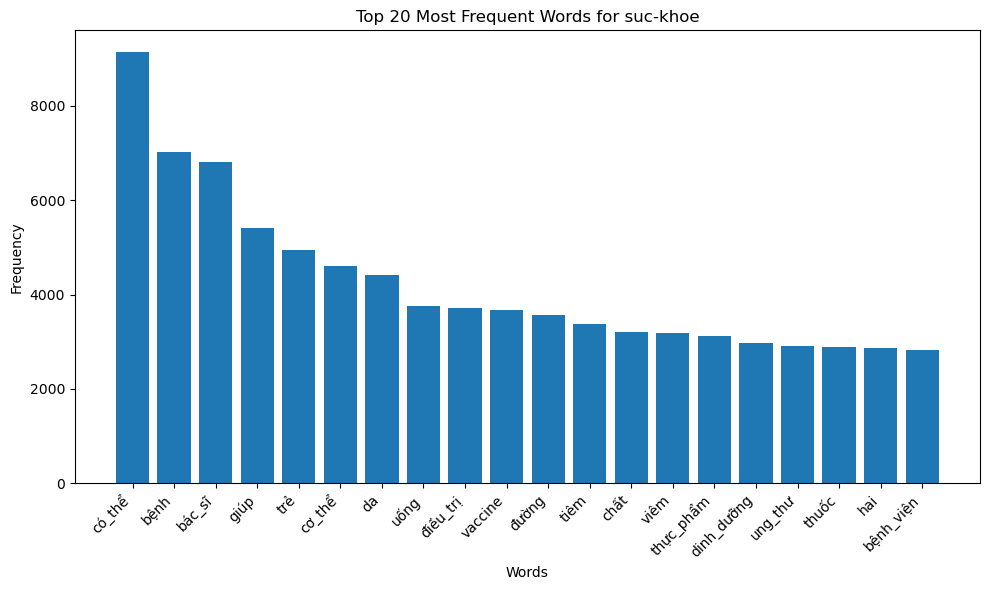

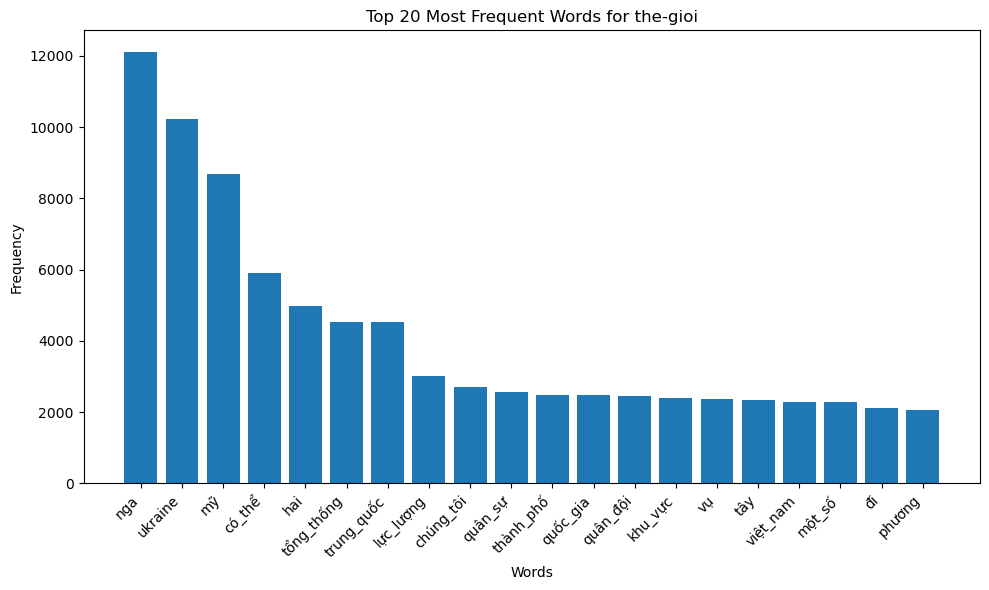

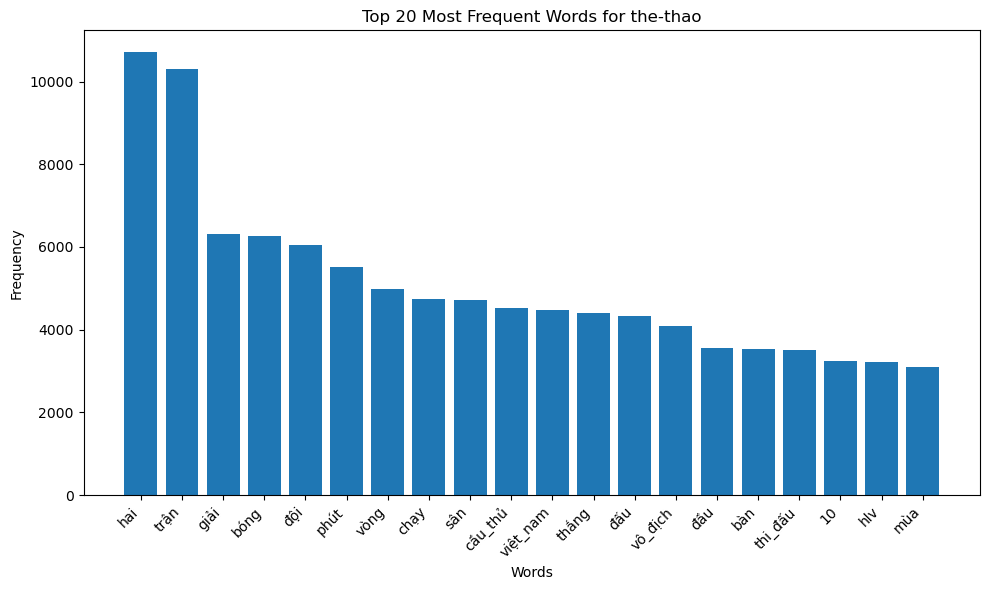

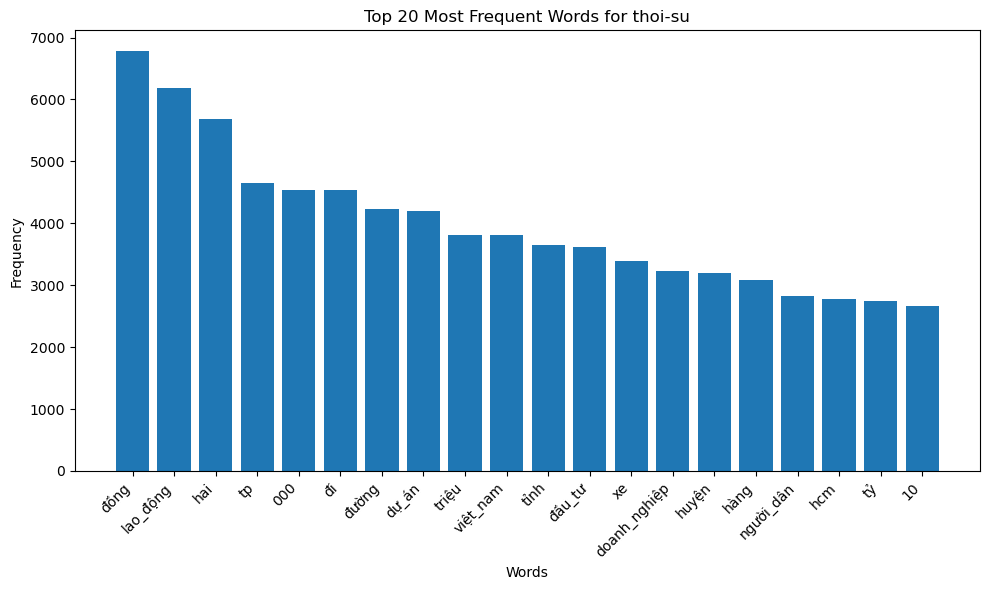

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

unique_labels = train['label'].unique() 

vectorizer = CountVectorizer()

for label in unique_labels:
    label_data = train[train['label'] == label]['cleaned_content']  
    X = vectorizer.fit_transform(label_data)
    
    word_frequencies = X.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    
    sorted_indices = word_frequencies.argsort()[::-1]
    sorted_words = [words[i] for i in sorted_indices]
    sorted_frequencies = word_frequencies[sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_words[:20], sorted_frequencies[:20])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 20 Most Frequent Words for {label}')
    plt.tight_layout()
    plt.show()


### Wordcloud for all label and for each label

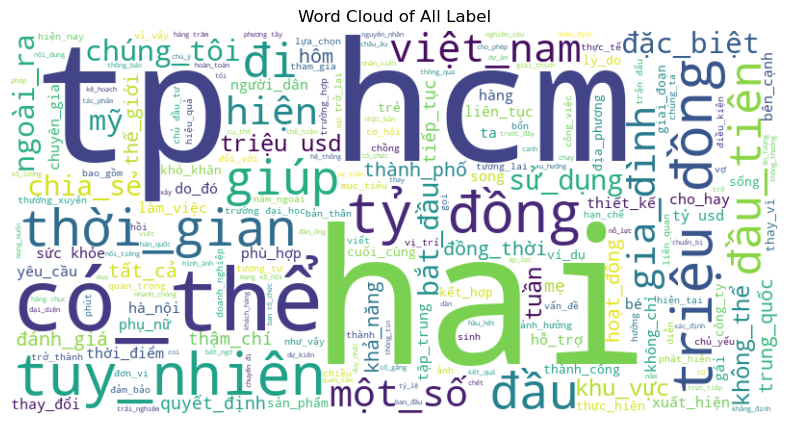

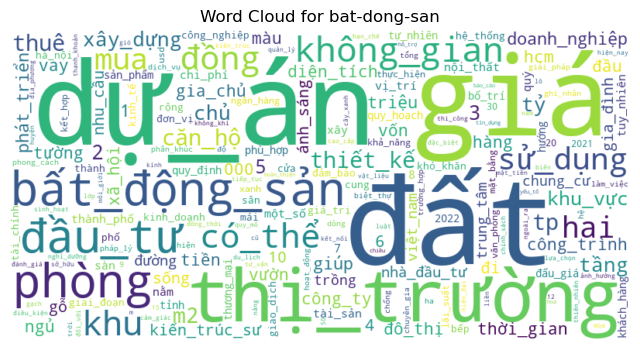

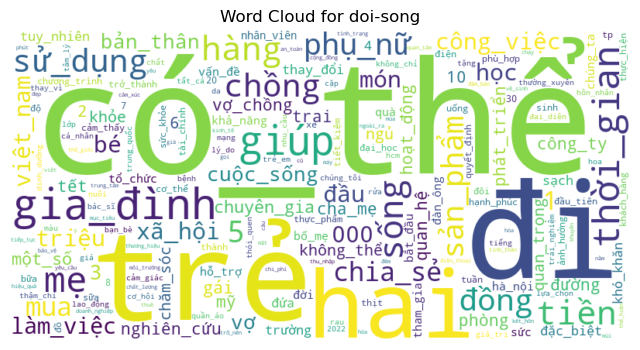

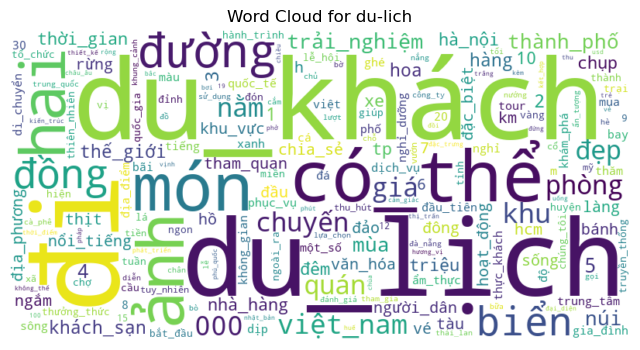

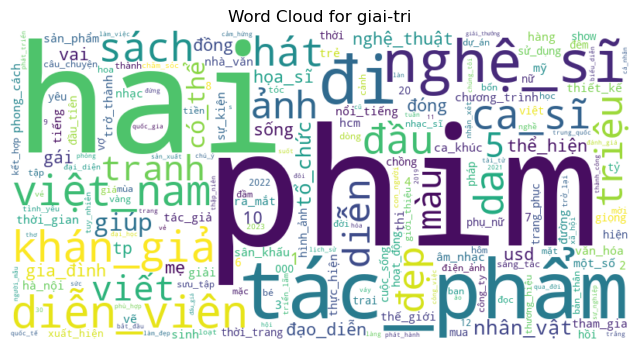

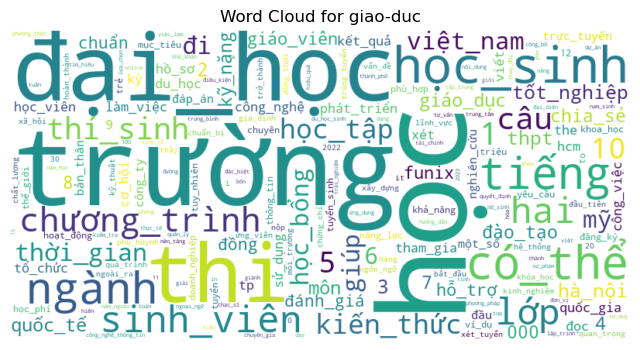

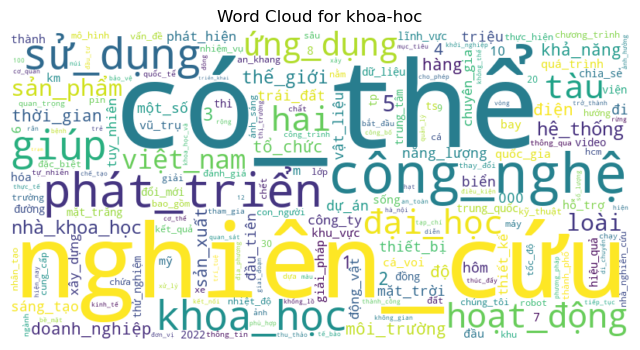

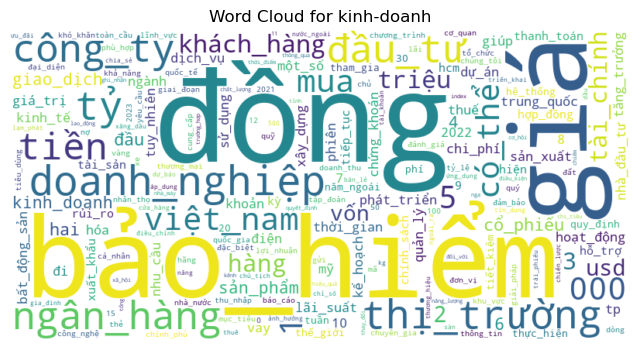

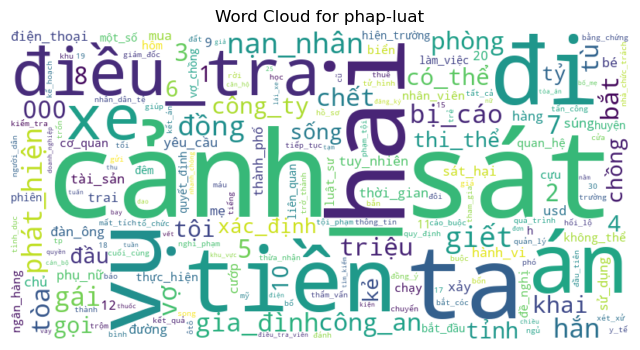

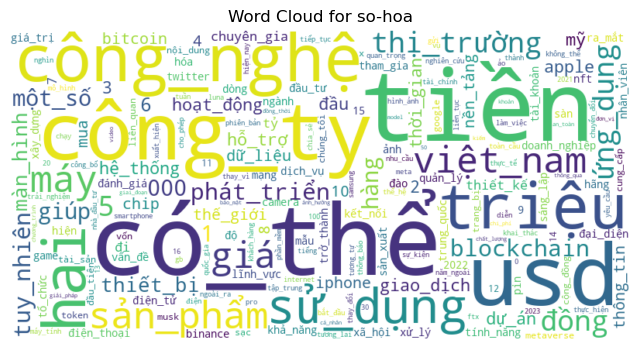

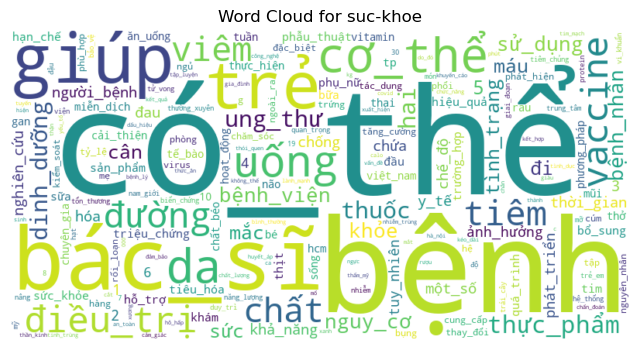

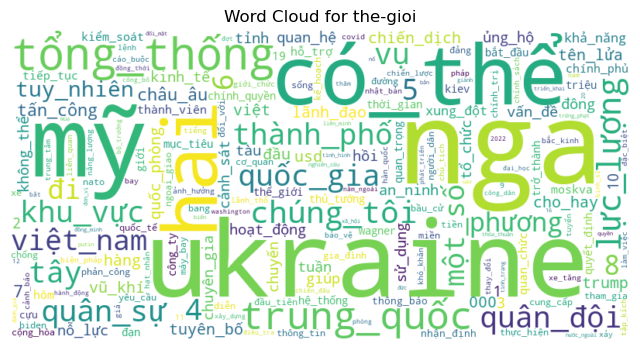

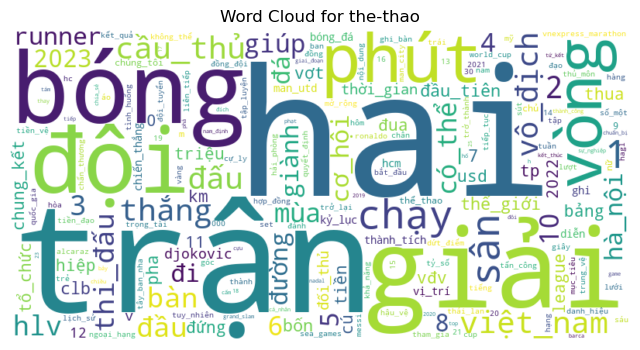

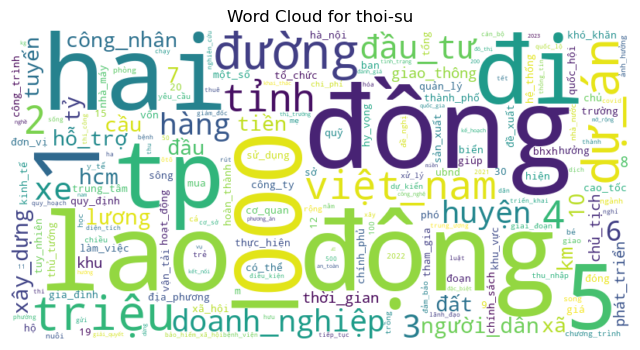

In [14]:
from wordcloud import WordCloud
from collections import Counter
from collections import defaultdict

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(content_data))

# Tạo thư mục để lưu các wordclouds
output_directory = 'wordclouds'
os.makedirs(output_directory, exist_ok=True)

# Wordcloud all data
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Label')
plt.savefig("./wordclouds/wordcloud_all_data.png", bbox_inches='tight')
plt.show()

# Tạo một từ điển để lưu tần suất của các từ theo nhãn
label_word_counts = defaultdict(Counter)

for index, row in train.iterrows():
    label = row['label']  
    words = row['cleaned_content'].split()
    label_word_counts[label].update(words)

# Vẽ và lưu Word Cloud cho từng nhãn
for label, word_count in label_word_counts.items():
    plt.figure(figsize=(8, 5))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_count)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label}')
    plt.axis('off')
    output_path = os.path.join(output_directory, f'wordcloud_{label}.png')
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()
    plt.close()


## Data splitting

### Divide X and y

In [10]:
X = train['cleaned_content']
y = train['label']

## Data Transformation

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

### Label Encoder

In [12]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
for label, encoded_value in label_mapping.items():
    print(f"{label}: {encoded_value}")

bat-dong-san: 0
doi-song: 1
du-lich: 2
giai-tri: 3
giao-duc: 4
khoa-hoc: 5
kinh-doanh: 6
phap-luat: 7
so-hoa: 8
suc-khoe: 9
the-gioi: 10
the-thao: 11
thoi-su: 12


### Train test split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42)

### TFIDT Vectorize

In [69]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgbm
from sklearn import metrics
import pickle

### Machine learning models

In [21]:
models = [
    ('LogisticRegression', LogisticRegression()),
    ('DecisionTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier()),
    ('XGBoost', xgb.XGBClassifier()),
    ('LightGBM', lgbm.LGBMClassifier()),
    ('SVM', SVC())
]

In [22]:
ml_models = []
models_directory = 'models'
os.makedirs(models_directory, exist_ok=True)

for name, model in models:
    model.fit(X_train_tfidf, y_train) 
    y_pred = model.predict(X_val_tfidf)  
    accuracy = metrics.accuracy_score(y_val, y_pred)
    ml_models.append({'Model Name': name,'Model': model, 'Accuracy': accuracy})
    model_filename = f"./models/{name}.pkl"
    with open(f'./models/{name}.pkl', 'wb') as file:
        pickle.dump(model, file)

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Machine learning DataFrame

In [23]:
ml_df = pd.DataFrame(ml_models,columns=['Model Name', 'Accuracy'])

In [24]:
ml_df.sort_values(by='Accuracy', ascending=False)

Model Name  Accuracy
4            LightGBM  0.929785
3             XGBoost  0.916512
5                 SVM  0.909689
0  LogisticRegression  0.906339
2        RandomForest  0.861680
1        DecisionTree  0.735889

### Deep learning models

In [14]:
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, SimpleRNN
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [15]:
max_words = 10000
max_sequence_length = 2000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [16]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length)

vocab_size = len(tokenizer.word_index) + 1

#### RNN model

In [ ]:
rnn = Sequential()
rnn.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length))
rnn.add(Dropout(0.3))
rnn.add(SimpleRNN(128, return_sequences=True))
rnn.add(Dropout(0.3))
rnn.add(SimpleRNN(64))
rnn.add(Dense(64, activation='relu'))
rnn.add(Dense(len(label_encoder.classes_), activation='softmax'))

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, min_delta = 0.005)
check_point = ModelCheckpoint('./models/rnn.h5', monitor='val_accuracy', save_best_only=True)

callbacks_rnn = [early_stopping, check_point]

In [35]:
rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# rnn = load_model('./models/rnn.h5')

In [23]:
history_rnn = rnn.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), \
                      epochs=50, batch_size = 64,callbacks = callbacks_rnn)

Epoch 1/50
378/378 [==============================] - 1220s 3s/step - loss: 0.2254 - accuracy: 0.9300 - val_loss: 0.8124 - val_accuracy: 0.8051
Epoch 2/50
378/378 [==============================] - 1275s 3s/step - loss: 0.2213 - accuracy: 0.9312 - val_loss: 0.8562 - val_accuracy: 0.8015
Epoch 3/50
378/378 [==============================] - 1337s 4s/step - loss: 0.2062 - accuracy: 0.9361 - val_loss: 0.8441 - val_accuracy: 0.8045
Epoch 4/50
378/378 [==============================] - 1206s 3s/step - loss: 0.2294 - accuracy: 0.9272 - val_loss: 0.8386 - val_accuracy: 0.8028
Epoch 5/50
378/378 [==============================] - 1243s 3s/step - loss: 0.2068 - accuracy: 0.9351 - val_loss: 0.8412 - val_accuracy: 0.8052
Epoch 6/50
378/378 [==============================] - 1175s 3s/step - loss: 0.1907 - accuracy: 0.9402 - val_loss: 0.8423 - val_accuracy: 0.8102
Epoch 7/50
378/378 [==============================] - 1203s 3s/step - loss: 0.1860 - accuracy: 0.9403 - val_loss: 0.9054 - val_accuracy:

In [24]:
rnn_best_model = load_model('./models/rnn.h5')

In [25]:
evaluation_rnn = rnn_best_model.evaluate(X_val_padded, y_val)
print(evaluation_rnn[1])

252/252 [==============================] - 43s 168ms/step - loss: 0.8423 - accuracy: 0.8102
0.8101972341537476


In [27]:
deep_model = []
deep_model.append({'Model Name': 'RNN', 'Accuracy': evaluation_rnn[1]})

#### LSTM model

In [54]:
lstm = Sequential()
lstm.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length))
lstm.add(SpatialDropout1D(0.3)),
lstm.add(LSTM(64))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(len(label_encoder.classes_), activation='softmax'))

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, min_delta = 0.005)
check_point = ModelCheckpoint('./models/lstm.h5', monitor='val_accuracy', save_best_only=True)
callbacks_lstm = [early_stopping, check_point]

In [55]:
lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
history_lstm = lstm.fit(X_train_padded, y_train, validation_data=(X_val_padded, y_val), \
                      epochs=50, batch_size = 64,callbacks = callbacks_lstm)

Epoch 1/50
378/378 [==============================] - 1156s 3s/step - loss: 1.4148 - accuracy: 0.5446 - val_loss: 0.8959 - val_accuracy: 0.7307
Epoch 2/50
378/378 [==============================] - 1221s 3s/step - loss: 0.7093 - accuracy: 0.7860 - val_loss: 0.7221 - val_accuracy: 0.7925
Epoch 3/50
378/378 [==============================] - 898s 2s/step - loss: 0.4611 - accuracy: 0.8608 - val_loss: 0.6410 - val_accuracy: 0.8159
Epoch 4/50
378/378 [==============================] - 858s 2s/step - loss: 0.3534 - accuracy: 0.8965 - val_loss: 0.5284 - val_accuracy: 0.8545
Epoch 5/50
378/378 [==============================] - 899s 2s/step - loss: 0.2688 - accuracy: 0.9183 - val_loss: 0.5360 - val_accuracy: 0.8494
Epoch 6/50
378/378 [==============================] - 874s 2s/step - loss: 0.2329 - accuracy: 0.9286 - val_loss: 0.6079 - val_accuracy: 0.8286
Epoch 7/50
378/378 [==============================] - 906s 2s/step - loss: 0.2053 - accuracy: 0.9366 - val_loss: 0.5509 - val_accuracy: 0.85

In [57]:
lstm_best_model = load_model('./models/lstm.h5')

In [59]:
evaluation_lstm = lstm_best_model.evaluate(X_val_padded, y_val)
print(evaluation_lstm[1])

252/252 [==============================] - 45s 176ms/step - loss: 0.5636 - accuracy: 0.8565
0.8564693927764893


In [60]:
deep_model.append({'Model Name': 'LSTM', 'Accuracy': evaluation_lstm[1]})

#### Deep learning DataFrame

In [61]:
deep_df = pd.DataFrame(deep_model)
deep_df.sort_values(by='Accuracy', ascending=False)

Model Name  Accuracy
1       LSTM  0.856469
0        RNN  0.810197

### Load model with high accuracy

In [62]:
with open('./models/LightGBM.pkl', 'rb') as model_file:
    load_best_model_ml = pickle.load(model_file)
load_best_model_dl = load_model('./models/lstm.h5')

## Read test data

In [63]:
test = pd.read_csv('./dataset/test.csv')
test.head()

content         label
0  10 loại cây giúp hút ẩm trong nhà \nThường xuâ...  bat-dong-san
1  10 loại cây trồng tốt cho sức khỏe\nNgoài chức...  bat-dong-san
2  10 mẫu bếp tối giản\nNhững căn bếp tối giả...  bat-dong-san
3  11 địa phương bị thanh tra quỹ đất nhà ở xã hộ...  bat-dong-san
4  2 tỷ đồng nên mua đất nền Đà Nẵng hay gửi tiết...  bat-dong-san

In [64]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  8068 non-null   object
 1   label    8068 non-null   object
dtypes: object(2)
memory usage: 126.2+ KB


### Preprocessing test data

In [66]:
test["cleaned_content"] = test["content"].apply(lambda x: text_preprocess(x))
test["cleaned_content"] = test["cleaned_content"].apply(lambda x: remove_stopwords(x, stopwords))

### Divide X_test and y_test

In [67]:
X_test = test['cleaned_content']
y_test = test['label']

### Transform X_test with tfidf and y_test with label_encoder

In [70]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_test = label_encoder.transform(y_test)

In [71]:
y_predict_ml = load_best_model_ml.predict(X_test_tfidf)
accuracy_ml = metrics.accuracy_score(y_predict_ml, y_test)
cm_ml = metrics.confusion_matrix(y_predict_ml, y_test)
print(accuracy_ml)

0.9300941993058999


### Transform X_test with padding 

In [72]:
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

In [73]:
y_predict_dl = load_best_model_dl.predict(X_test_padded)
accuracy_dl = metrics.accuracy_score(np.argmax(y_predict_dl, axis =1), y_test)
cm_dl = metrics.confusion_matrix(np.argmax(y_predict_dl, axis =1), y_test)
print(accuracy_dl)

253/253 [==============================] - 45s 174ms/step
0.858329201784829


In [74]:
y_predict_ml = label_encoder.inverse_transform(y_predict_ml)
y_predict_dl = label_encoder.inverse_transform(np.argmax(y_predict_dl, axis =1))
y_test = label_encoder.inverse_transform(y_test)

### Confusion matrix 

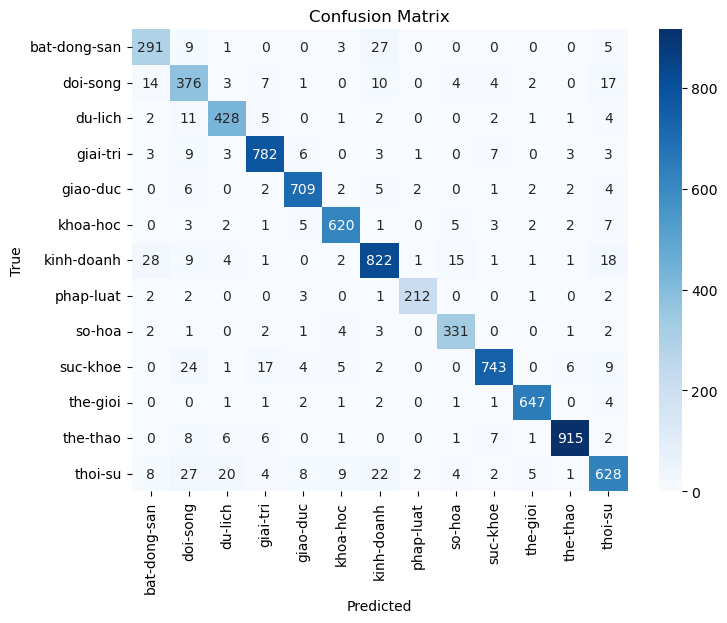

In [75]:
class_names = np.unique(np.concatenate((y_test, y_predict_ml)))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ml, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

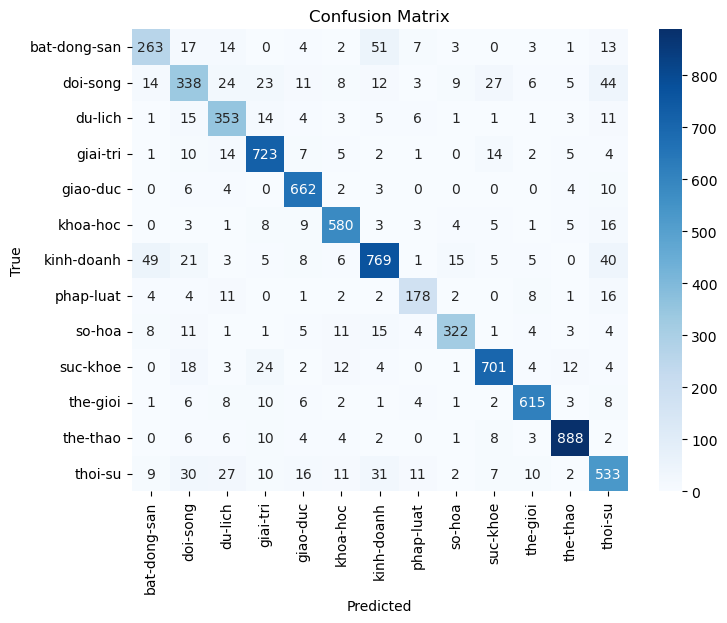

In [76]:
class_names = np.unique(np.concatenate((y_test, y_predict_dl)))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dl, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### DataFrame predict and test data to file csv

In [77]:
predict_df_ml = pd.DataFrame({
    'Prediction':y_predict_ml,
    'y_test':y_test,
})
predict_df_ml.to_csv('./dataset/predicted_ml.csv', index=False)

In [78]:
predict_df_dl = pd.DataFrame({
    'Prediction':y_predict_dl,
    'y_test':y_test,
})

predict_df_dl.to_csv('./dataset/predicted_dl.csv', index=False)